In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error

# Configure warnings and plot style
warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


In [2]:
def load_and_merge_csv_data(data_dir):
    dfs = []
    labels = []
    for root, subfolders, _ in os.walk(data_dir):
        label_index = 0
        for folder in subfolders:
            if folder != 'NF':
                path = os.path.join(root, folder)
                print(f"Processing folder: {path}")
                for file in glob.glob(os.path.join(path, '*.csv')):
                    df = pd.read_csv(file)
                    df = df.iloc[300:13700, :]
                    dfs.append(df)
                    labels.append(label_index)
                label_index += 1
    merged_df = pd.concat(dfs).reset_index(drop=True)
    return merged_df, np.array(labels)

data_path = r'C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data'
merged_data, labels = load_and_merge_csv_data(data_path)
print(f"Total labels loaded: {labels.shape[0]}")


Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LG
Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LL
Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\LLG
Processing folder: C:\Users\Victor\Desktop\Data Science works\papers\autoencoder vs HLLE\long data\TLG
Total labels loaded: 4


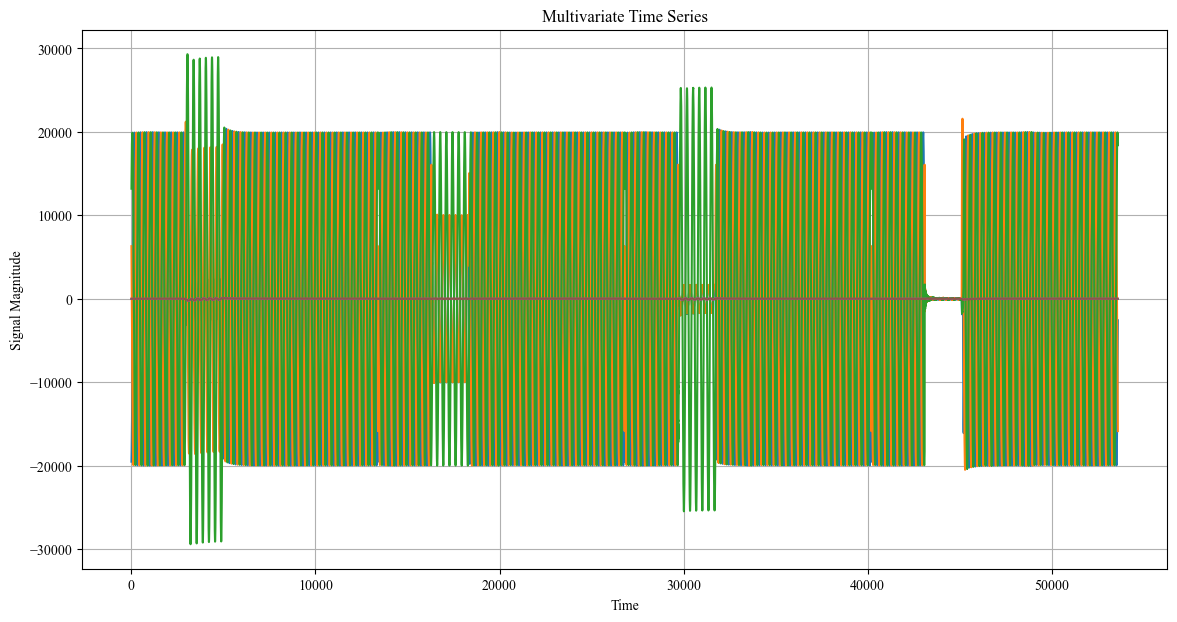

In [3]:
def plot_timeseries(dataframe, start_col=1, end_col=7):
    X = dataframe.iloc[:, start_col:end_col].values
    time_axis = dataframe.iloc[:, 0].values
    plt.figure(figsize=(14, 7))
    plt.plot(X)
    plt.xlabel("Time")
    plt.ylabel("Signal Magnitude")
    plt.title("Multivariate Time Series")
    plt.grid(True)
    plt.show()

plot_timeseries(merged_data)


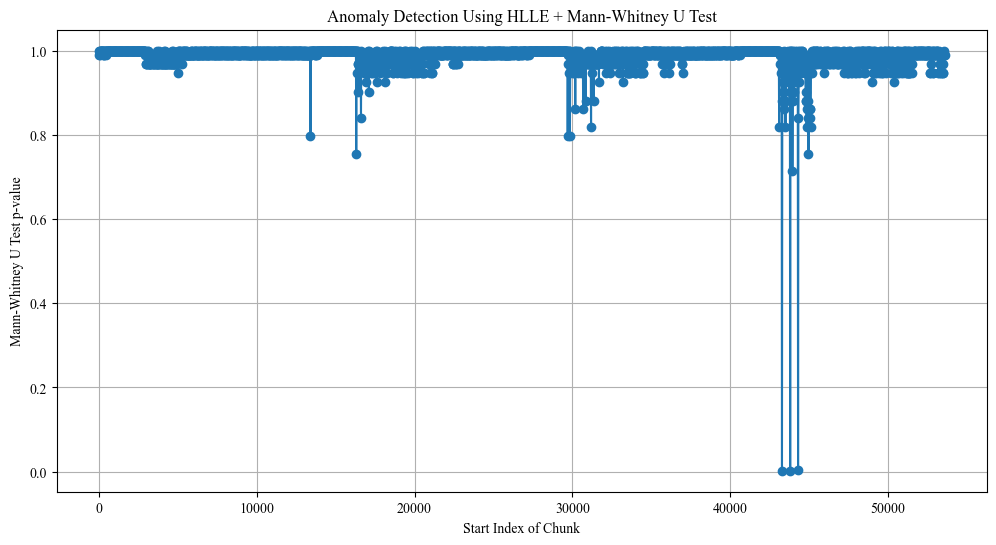

In [4]:
def hlle_mann_whitney_test(data, chunk_size=20, neighbors=6, components=1):
    X = data.iloc[:, 1:].values
    baseline = X[:chunk_size, :]
    hlle = LocallyLinearEmbedding(n_neighbors=neighbors, n_components=components, method='hessian', eigen_solver='dense')
    baseline_proj = hlle.fit_transform(baseline).flatten()
    p_values = []
    step_indices = []
    for i in range(0, len(X), chunk_size):
        chunk = X[i:i + chunk_size, :]
        if len(chunk) < chunk_size:
            break
        chunk_proj = hlle.fit_transform(chunk).flatten()
        _, p_value = stats.mannwhitneyu(baseline_proj, chunk_proj)
        p_values.append(p_value)
        step_indices.append(i)
    plt.figure(figsize=(12, 6))
    plt.plot(step_indices, p_values, marker='o')
    plt.xlabel("Start Index of Chunk")
    plt.ylabel("Mann-Whitney U Test p-value")
    plt.title("Anomaly Detection Using HLLE + Mann-Whitney U Test")
    plt.grid(True)
    plt.show()
    return np.array(p_values), step_indices

p_values, steps = hlle_mann_whitney_test(merged_data)


In [5]:
def reshape_pvalues(p_array, group_size=670):
    reshaped = [p_array[i:i + group_size] for i in range(0, len(p_array), group_size)]
    return pd.DataFrame(np.array(reshaped).T)

pval_df = reshape_pvalues(p_values)
pval_df.head()


,0,1,2,3
0,1.000000,0.797197,1.000000,1.000000
1,0.989209,0.989209,0.989209,0.989209
2,1.000000,1.000000,1.000000,1.000000
3,0.989209,0.989209,0.989209,0.989209
4,1.000000,1.000000,1.000000,1.000000


In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

def evaluate_model(true_labels, predicted_labels):
    '''
    Evaluate a classification model and display the confusion matrix and standard metrics.
    '''
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    # Print evaluation metrics
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"F1-score     : {f1:.4f}")
    print(f"Specificity  : {specificity:.4f}")

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Fault', 'Fault'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# evaluate_model(merged['LABEL'], pred_labels)


In [7]:
# Step to reshape p_val and define vals
vals = []
for i in range(0, len(p_val), 670):
    vals.append(p_val[i:i + 670])
vals = np.array(vals).T  # Transpose to match original layout: shape (670, 4)


NameError: name 'p_val' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Threshold-based prediction from p-value matrix (vals)
def generate_predictions_from_pvals(vals, threshold=0.9892, segment_size=13400, chunk_size=20):
    pred_segments = []
    size = vals.shape[0]  # should be 670

    for i in range(vals.shape[1]):  # number of segments, typically 4
        indi = np.zeros(segment_size)
        start = end = 0
        for j in range(size):
            if j >= 100 and vals[j, i] < threshold:
                start = j
                break
        if start != 0:
            for j in range(start + 1, size - 8):
                if vals[j, i] > threshold:
                    flag = all(vals[j + k, i] > threshold for k in range(8))
                    if flag:
                        end = j
                        break
        for j in range(start, end + 1):
            indi[j * chunk_size : j * chunk_size + chunk_size] = 1
        pred_segments.append(indi)

    return np.concatenate(pred_segments).astype(int)

# Generate predictions
pred_labels = generate_predictions_from_pvals(vals.T)

# Ground truth labels from merged_data
ground_truth_labels = merged_data['LABEL'][:len(pred_labels)]

# Evaluate model performance
evaluate_model(ground_truth_labels, pred_labels)
